In [1]:
# Basic NGSolve things
from netgen.geom2d import SplineGeometry
from ngsolve import *

# ngsxfem and the mlset convenience layer 
from xfem import *
from xfem.mlset import *

import matplotlib.pyplot as plt
import numpy as np
import matplotlib 
matplotlib.rcParams.update({'font.size': 18})

# reference data from MFD
ref1 = np.loadtxt('data/REF_0p50p9LR.csv',comments='#',delimiter=',',skiprows=1)
ref2 = np.loadtxt('data/REF_0p50p9.csv',comments='#',delimiter=',',skiprows=1)

# mesh

In [2]:
# Complex
from read_gmsh import ReadGmsh
mesh = ReadGmsh("mesh/complex.msh")
from ngsolve import Mesh
mesh = Mesh(mesh)

eps = 1e-6
for e in mesh.Elements(BND):
    p0 = mesh[e.vertices[0]].point
    p1 = mesh[e.vertices[1]].point
    if abs(p0[0]-0)<eps and abs(p1[0]-0)< eps:
        mesh.ngmesh.SetBCName(e.index, "left")
    elif abs(p0[0]-1)<eps and abs(p1[0]-1)< eps:
        mesh.ngmesh.SetBCName(e.index, "right")
    elif abs(p0[1]-1)<eps and abs(p1[1]-1)< eps:
        mesh.ngmesh.SetBCName(e.index, "top")
    elif abs(p0[1]-0)<eps and abs(p1[1]-0)< eps:
        mesh.ngmesh.SetBCName(e.index, "bottom")
    elif (abs((p0[0]-0.15)/(0.15-0.4)-(p0[1]-0.9167)/(0.9167-0.5))<eps and 
          abs((p1[0]-0.15)/(0.15-0.4)-(p1[1]-0.9167)/(0.9167-0.5))<eps): 
        mesh.ngmesh.SetBCName(e.index, "barr")
    elif (abs((p0[0]-0.65)/(0.65-0.849723)-(p0[1]-0.8333)/(0.8333-0.167625))<10*eps and 
          abs((p1[0]-0.65)/(0.65-0.849723)-(p1[1]-0.8333)/(0.8333-0.167625))<10*eps): 
        mesh.ngmesh.SetBCName(e.index, "barr")
    else:
        mesh.ngmesh.SetBCName(e.index, "frac")

# barrier cfs
# mesh.Refine()
from netgen.meshing import Element0D

pts=[[0.185, 0.856], [0.850,0.168], [0.815, 0.283], [0.662, 0.793]]
# 0D nodes
for k in range(4):
    for i, p in enumerate(mesh.ngmesh.Points()):
        if abs(p.p[0]-pts[k][0])+abs(p.p[1]-pts[k][1]) < 1e-2:
            mesh.ngmesh.Add(Element0D(i+1, index=1))
mesh.ngmesh.SetCD2Name(1, "cut") # barrier/fracture cuts


mesh = Mesh(mesh.ngmesh)
print(mesh.GetBBoundaries())

gfu = GridFunction(H1(mesh))
gfu.Set(1,definedon=mesh.Boundaries("frac"))
gfv = GridFunction(H1(mesh))
gfv.Set(-1,definedon=mesh.Boundaries("barr"))
gfw = GridFunction(H1(mesh))
gfw.Set(1.1, definedon=mesh.BBoundaries("cut"))
Draw(gfv+gfu+gfw, mesh,"ff")

V = Compress(SurfaceL2(mesh, order=0, definedon=mesh.Boundaries("frac|barr")))
print("matrix elements: ", mesh.ne, "; fracture elements: ", V.ndof)

('cut',)


WebGuiWidget(value={'ngsolve_version': '6.2.2103-72-g646b7caba', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'd…

matrix elements:  1332 ; fracture elements:  88


# Case 1

WebGuiWidget(value={'ngsolve_version': '6.2.2103-72-g646b7caba', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'd…

Total:  7518  Global:  2190 V:  3996 W:  1332 M:  1998 Vf:  124 Mf:  68


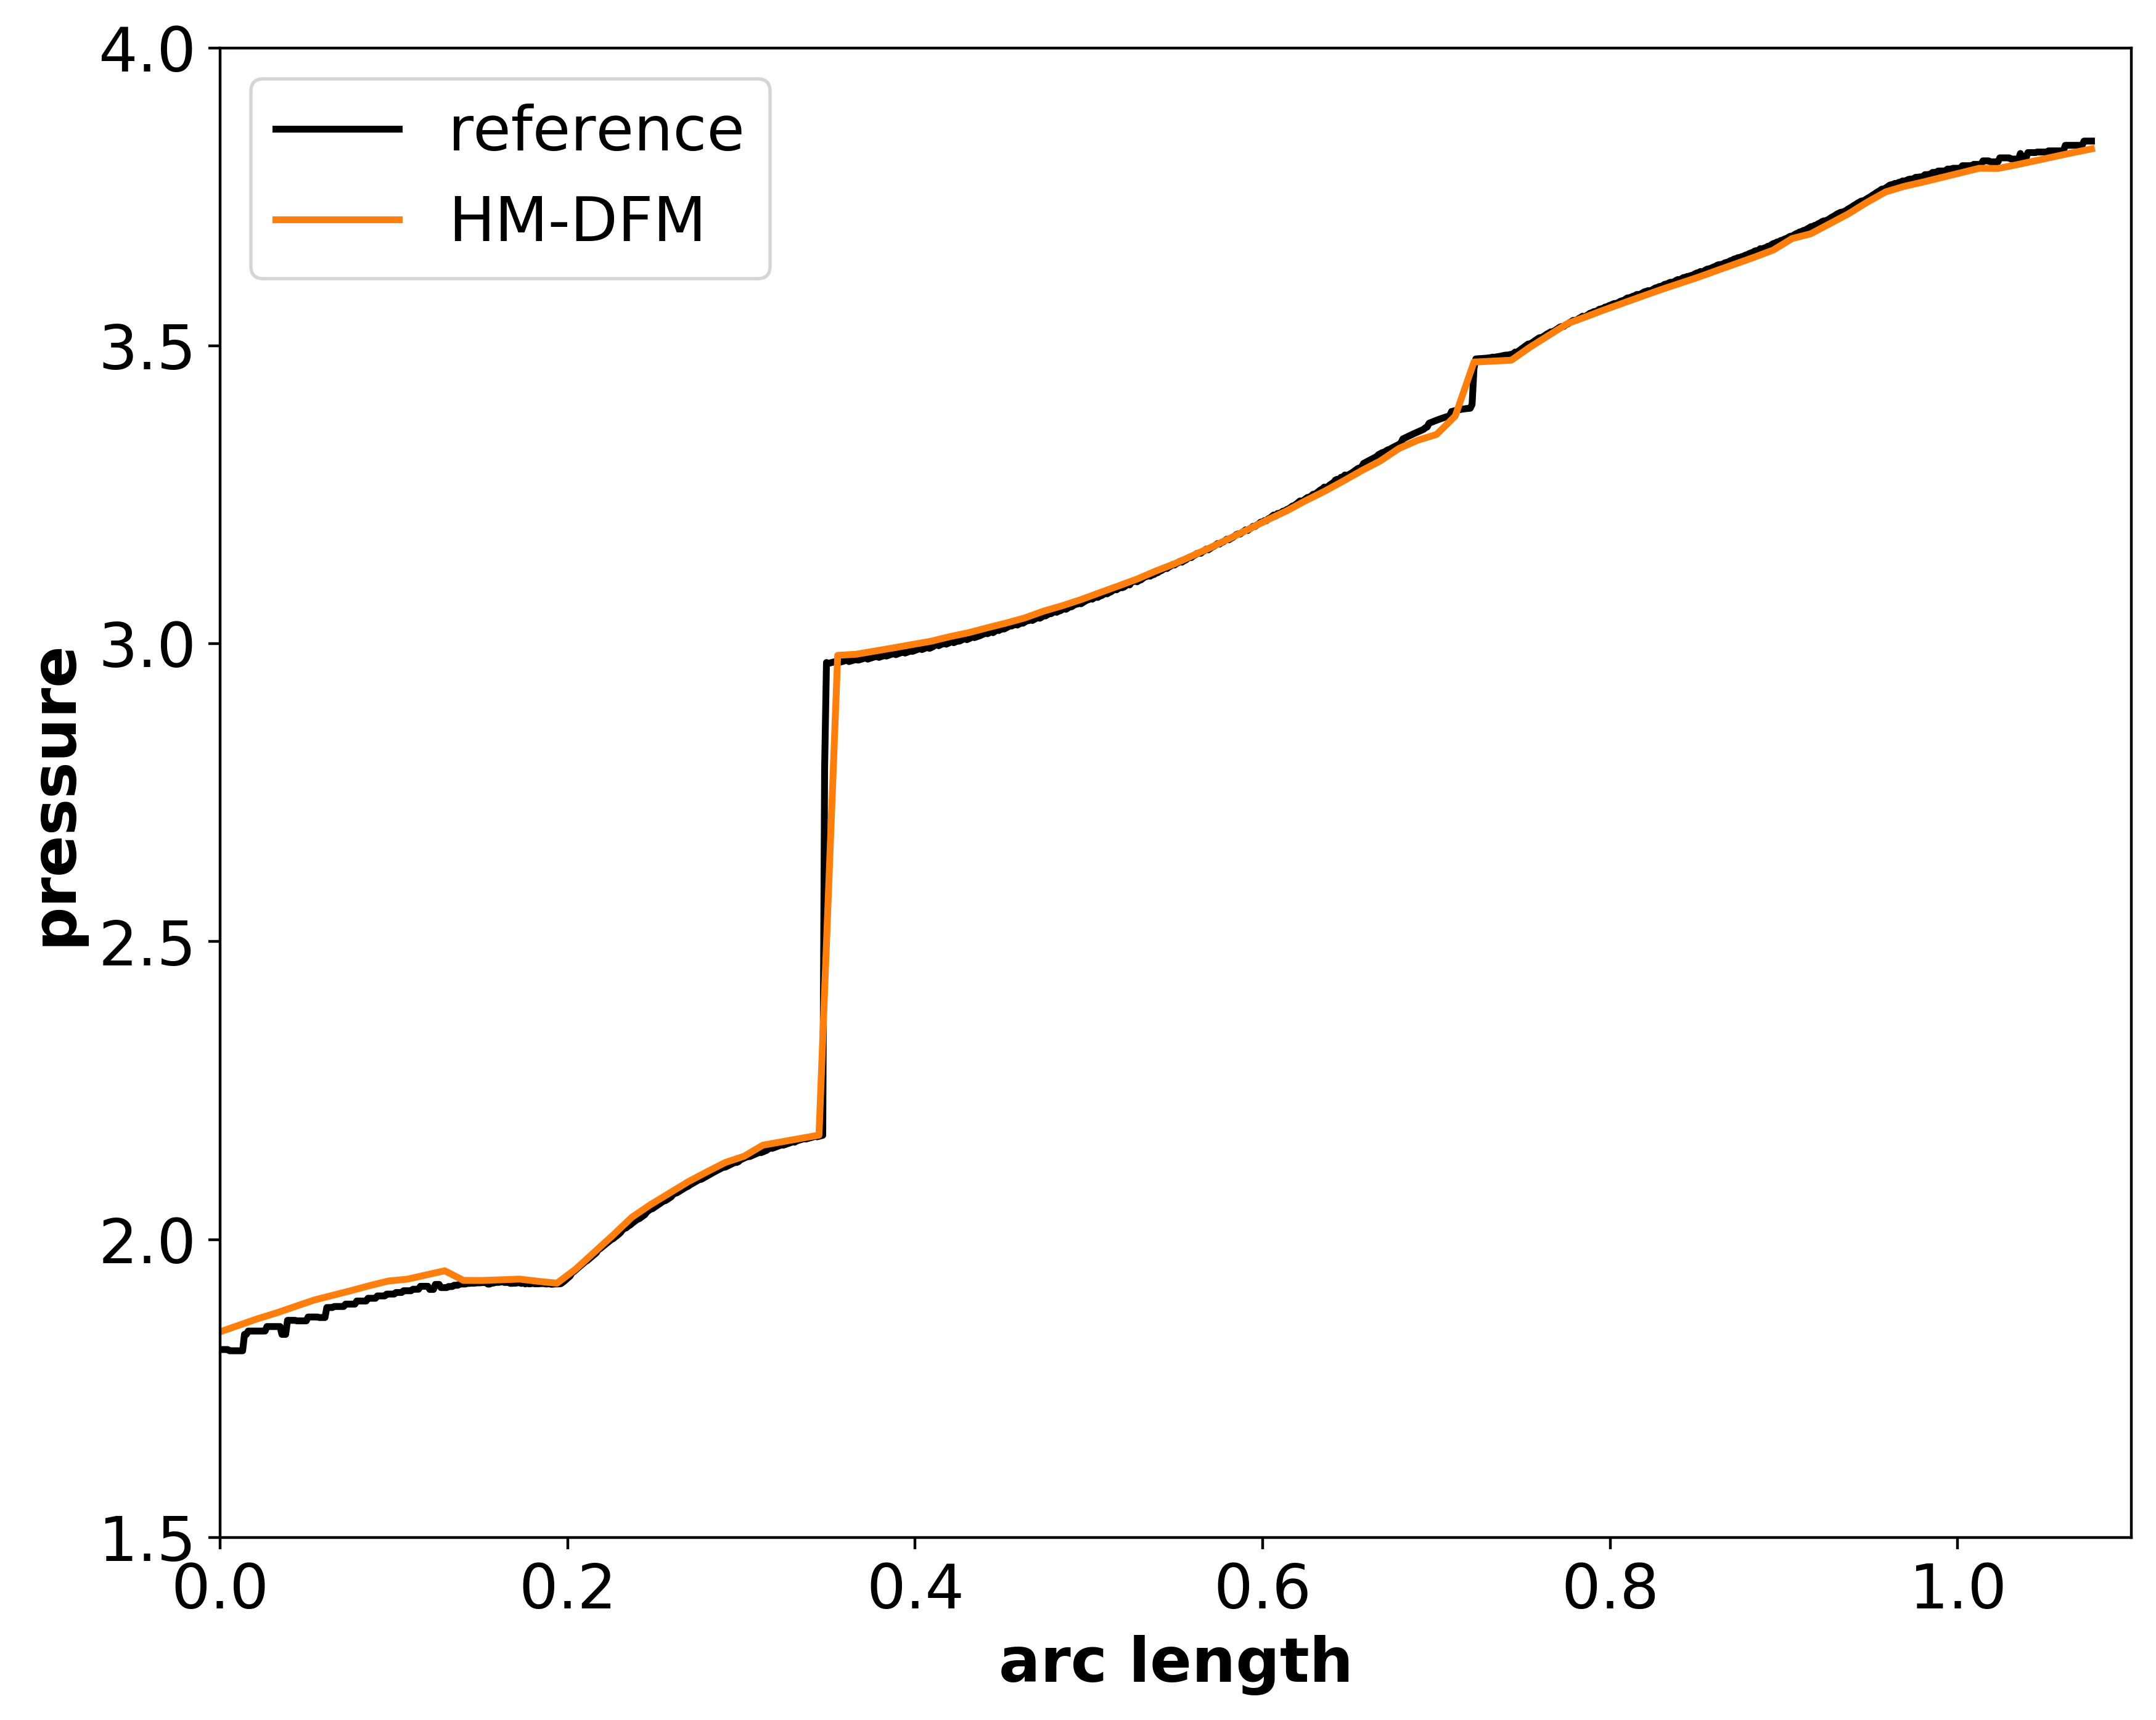

In [3]:
# each fracture is represented by a mlset with 2 level set functions (line+circle)
level_sets_p1 = tuple(tuple(GridFunction(H1(mesh, order=1)) for i in range(2)) for j in range(2))
eps0 = 1e-3
frac0 = np.array([[1, 0.15, 0.9167, 0.4, 0.5], 
         [2, 0.65,0.8333-eps0, 0.849723,0.167625-eps0]])
# interface indicator/interface elements/tangential directions
nfs = 2
lset_ifs = [None for j in range(nfs)]
lset_elems = [None for j in range(nfs)]
ts = [None for j in range(nfs)]
ns = [None for j in range(nfs)]

# all fractures
for i, lset_p1 in enumerate(level_sets_p1):
    x0, y0, x1, y1 = frac0[i][1], frac0[i][2],frac0[i][3],frac0[i][4]
    l1 = (x-x0)/(x1-x0)-(y-y0)/(y1-y0)
    len1 = sqrt((x1-x0)**2+(y1-y0)**2)
    xmid, ymid = 0.5*(x0+x1), 0.5*(y0+y1)
    r1 = sqrt((x-xmid)**2+(y-ymid)**2)-0.5*len1
    InterpolateToP1(l1, lset_p1[0]) # line segment
    InterpolateToP1(r1, lset_p1[1]) # circ
    mlci = MultiLevelsetCutInfo(mesh, lset_p1)
    frac = DomainTypeArray((IF, NEG))
    lset_ifs[i] = {"levelset": lset_p1, "domain_type": frac, "subdivlvl" : 0}
    lset_elems[i] = mlci.GetElementsWithContribution(frac)
    n1 = 1.0/grad(lset_p1[0]).Norm() * grad(lset_p1[0])
    ts[i] = CoefficientFunction((-n1[1], n1[0]))
    ns[i] = n1
    if i ==0:
        bitarray = BitArrayCF(lset_elems[i])
    else:
        bitarray += BitArrayCF(lset_elems[i])

# draw the interface elements for the fracture
# Draw(bitarray, mesh, max=1)

# hybrid-mixed solver: GOOD
order = 0
frac = "frac"
V = HDiv(mesh, order=order, RT=True, discontinuous=True)
W = L2(mesh, order=order)
M = FacetFESpace(mesh, order=order, dirichlet="top|bottom")
Vf = Compress(SurfaceL2(mesh, order=order+1, definedon=mesh.Boundaries(frac)))
Mf = Compress(H1(mesh, order=1, definedon=mesh.Boundaries(frac)))

fes = V*W*M*Vf*Mf
(u, p, phat, uf, pbar), (v, q, qhat, vf, qbar) = fes.TnT()

eps = 1e-4
K0, K1, K2 = 1, 1e4, 1e-4

condense=True
a = BilinearForm(fes, condense=condense)
h = specialcf.mesh_size
n = specialcf.normal(2)
t = specialcf.tangential(2)
# subdomain 1
a += (1/K0*u*v-p*div(v)-q*div(u))*dx
a += (1/eps/K1*uf.Trace()*vf.Trace()-phat.Trace()*grad(vf).Trace()*t-qhat.Trace()*grad(uf).Trace()*t
     )*ds("frac")
a += (v*n*phat+u*n*qhat)*dx(element_boundary=True)
gfn = GridFunction(Compress(SurfaceL2(mesh, order=1, definedon=mesh.Boundaries(frac))))
count = 0
for e in mesh.Elements(BND):
    if e.mat=="frac":
        if e.vertices[0].nr > e.vertices[1].nr:
            gfn.vec[2*count+1] = -1
        else:
            gfn.vec[2*count+1] = 1 
        count += 1    
a += (pbar*vf*gfn+uf*qbar*gfn)*ds(element_boundary=True, definedon="frac")
# Hack a Neumann BC
gfX = GridFunction(H1(mesh))
gfX.Set(1, definedon=mesh.BBoundaries("cut"))
a += gfX*1e8/eps/K1*(uf*vf)*ds(element_boundary=True, definedon="frac")
for i in range(nfs):
    a += SymbolicBFI(levelset_domain = lset_ifs[i], 
                 form = eps/K2 * u*ns[i] * v*ns[i],
                definedonelements=lset_elems[i])


########### TODO

f = LinearForm(fes)

gfu = GridFunction(fes)

a.Assemble()
f.Assemble()

# top dirichlet data
gfu.components[2].Set(1+3*y, definedon=mesh.Boundaries("top|bottom"))

f.vec.data -= a.mat*gfu.vec
if condense==True:
    f.vec.data += a.harmonic_extension_trans * f.vec
gfu.vec.data += a.mat.Inverse(fes.FreeDofs(condense), inverse="umfpack")*f.vec
if condense==True:
    gfu.vec.data += a.harmonic_extension * gfu.vec 
    gfu.vec.data += a.inner_solve * f.vec

# Local postprocessing
V2 = L2(mesh, order=1, all_dofs_together=False)
ph = GridFunction(V2)

a2 = BilinearForm(V2)
f2 = LinearForm(V2)

p2, q2 = V2.TnT()
a2 += grad(p2)*grad(q2)*dx
a2.Assemble()
f2 += -K0*gfu.components[0]*grad(q2)*dx
f2.Assemble()

V2.FreeDofs()[:mesh.ne]=False
ph.vec[:mesh.ne].data=gfu.components[1].vec
ph.vec.data += a2.mat.Inverse(V2.FreeDofs())*f2.vec
    
Draw(ph, mesh, "soln")
# save data to vtk format for better visualization
vtkout = VTKOutput(ma=mesh, coefs=[ph], names=["pres"], filename="data/complexA")
vtkout.Do()


xx = np.linspace(0, 1, 101)
pre = np.array([ph(mesh(xx0,0.9+(xx0-1)*0.4)) for xx0 in xx])


plt.figure(figsize=(10,8), dpi=400)

print("Total: ", sum(fes.FreeDofs()), " Global: ", sum(fes.FreeDofs(True)), 
     "V: ", sum(V.FreeDofs()), "W: ", sum(W.FreeDofs()), "M: ", sum(M.FreeDofs()), 
     "Vf: ", sum(Vf.FreeDofs(True)), "Mf: ", sum(Mf.FreeDofs(True)))
plt.plot(ref2.T[3]*(1.16)**0.5, ref2.T[0], "k", linewidth=2)
plt.plot(xx*(1.16)**0.5, pre, 'C1', linewidth=2)
plt.legend(["reference", "HM-DFM"])
plt.axis([0,1.1, 1.5,4])
plt.xlabel("arc length", fontweight='bold')
plt.ylabel("pressure", fontweight='bold')
plt.savefig("data/complexA.pdf", dpi=400)

# Case 2

WebGuiWidget(value={'ngsolve_version': '6.2.2103-72-g646b7caba', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'd…

Total:  7518  Global:  2190 V:  3996 W:  1332 M:  1998 Vf:  124 Mf:  68


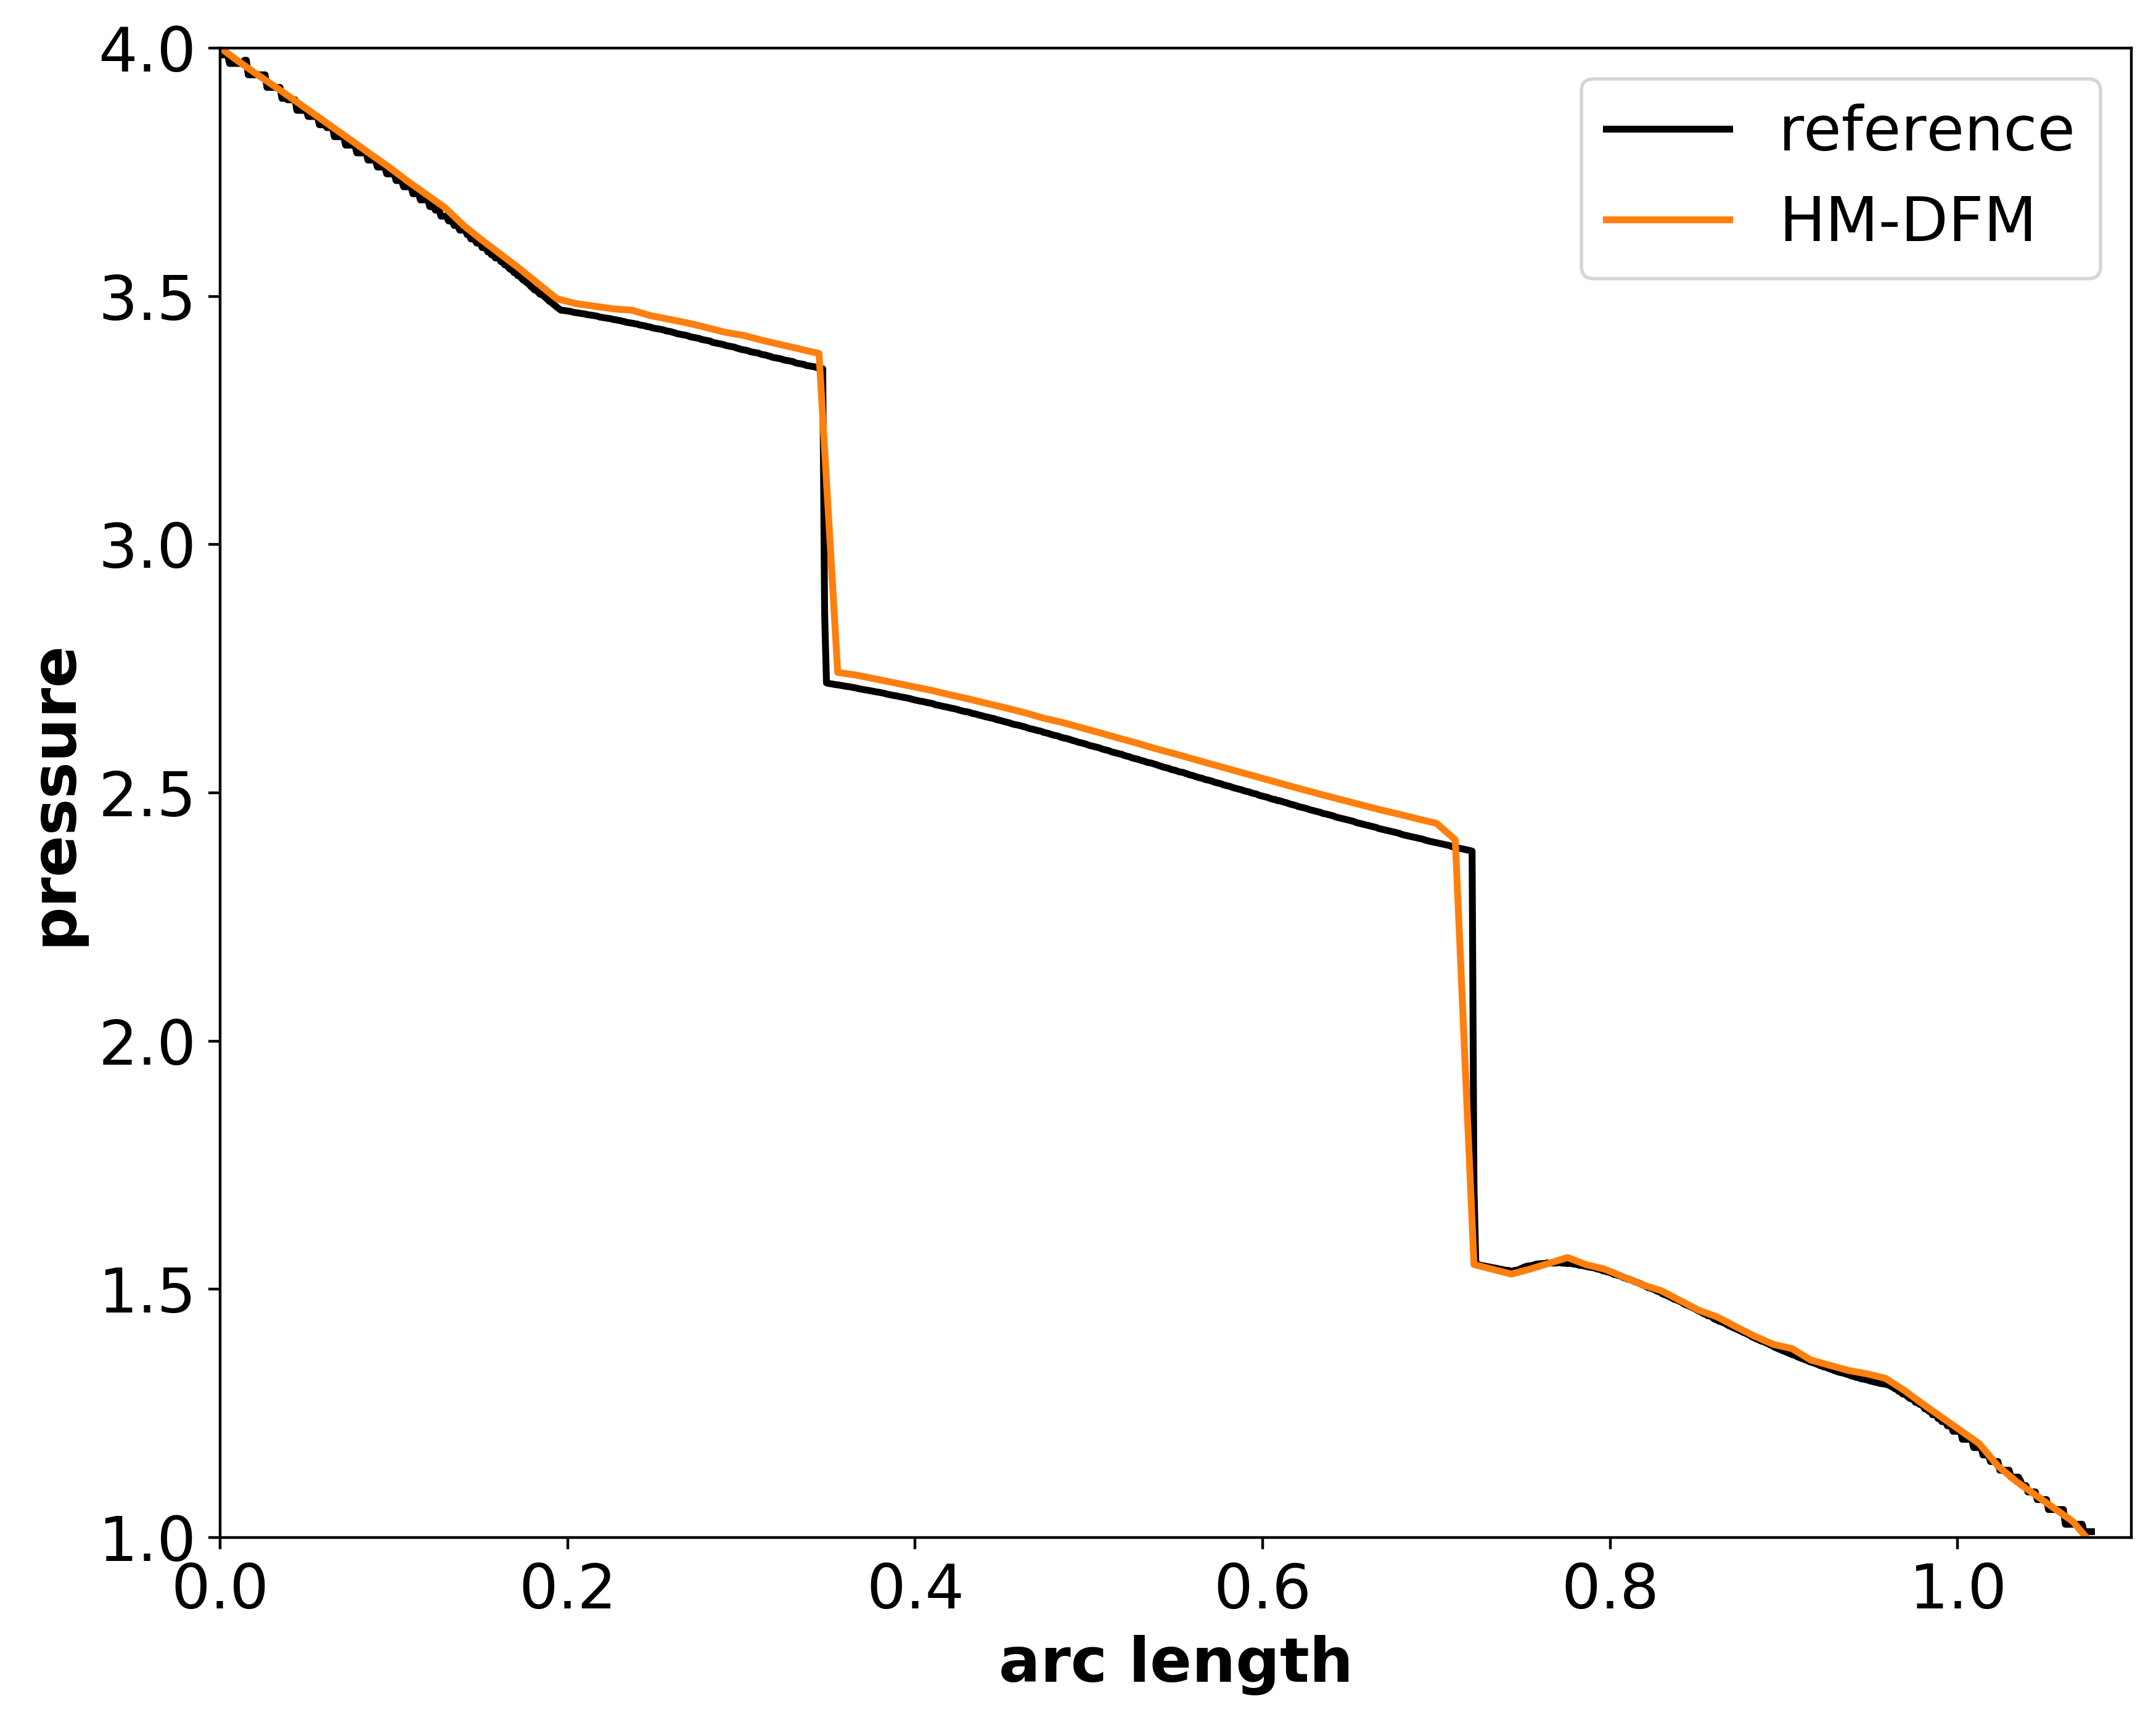

In [4]:
# each fracture is represented by a mlset with 2 level set functions (line+circle)
level_sets_p1 = tuple(tuple(GridFunction(H1(mesh, order=1)) for i in range(2)) for j in range(2))
eps0 = 1e-3
frac0 = np.array([[1, 0.15, 0.9167, 0.4, 0.5], 
         [2, 0.65,0.8333-eps0, 0.849723,0.167625-eps0]])
# interface indicator/interface elements/tangential directions
nfs = 2
lset_ifs = [None for j in range(nfs)]
lset_elems = [None for j in range(nfs)]
ts = [None for j in range(nfs)]
ns = [None for j in range(nfs)]

# all fractures
for i, lset_p1 in enumerate(level_sets_p1):
    x0, y0, x1, y1 = frac0[i][1], frac0[i][2],frac0[i][3],frac0[i][4]
    l1 = (x-x0)/(x1-x0)-(y-y0)/(y1-y0)
    len1 = sqrt((x1-x0)**2+(y1-y0)**2)
    xmid, ymid = 0.5*(x0+x1), 0.5*(y0+y1)
    r1 = sqrt((x-xmid)**2+(y-ymid)**2)-0.5*len1
    InterpolateToP1(l1, lset_p1[0]) # line segment
    InterpolateToP1(r1, lset_p1[1]) # circ
    mlci = MultiLevelsetCutInfo(mesh, lset_p1)
    frac = DomainTypeArray((IF, NEG))
    lset_ifs[i] = {"levelset": lset_p1, "domain_type": frac, "subdivlvl" : 0}
    lset_elems[i] = mlci.GetElementsWithContribution(frac)
    n1 = 1.0/grad(lset_p1[0]).Norm() * grad(lset_p1[0])
    ts[i] = CoefficientFunction((-n1[1], n1[0]))
    ns[i] = n1
    if i ==0:
        bitarray = BitArrayCF(lset_elems[i])
    else:
        bitarray += BitArrayCF(lset_elems[i])

# draw the interface elements for the fracture
# Draw(bitarray, mesh, max=1)

# hybrid-mixed solver: GOOD
order = 0
frac = "frac"
V = HDiv(mesh, order=order, RT=True, discontinuous=True)
W = L2(mesh, order=order)
M = FacetFESpace(mesh, order=order, dirichlet="left|right")
Vf = Compress(SurfaceL2(mesh, order=order+1, definedon=mesh.Boundaries(frac)))
Mf = Compress(H1(mesh, order=1, definedon=mesh.Boundaries(frac)))

fes = V*W*M*Vf*Mf
(u, p, phat, uf, pbar), (v, q, qhat, vf, qbar) = fes.TnT()

eps = 1e-4
K0, K1, K2 = 1, 1e4, 1e-4

condense=True
a = BilinearForm(fes, condense=condense)
h = specialcf.mesh_size
n = specialcf.normal(2)
t = specialcf.tangential(2)
# subdomain 1
a += (1/K0*u*v-p*div(v)-q*div(u))*dx
a += (1/eps/K1*uf.Trace()*vf.Trace()-phat.Trace()*grad(vf).Trace()*t-qhat.Trace()*grad(uf).Trace()*t
     )*ds("frac")
a += (v*n*phat+u*n*qhat)*dx(element_boundary=True)
gfn = GridFunction(Compress(SurfaceL2(mesh, order=1, definedon=mesh.Boundaries(frac))))
count = 0
for e in mesh.Elements(BND):
    if e.mat=="frac":
        if e.vertices[0].nr > e.vertices[1].nr:
            gfn.vec[2*count+1] = -1
        else:
            gfn.vec[2*count+1] = 1 
        count += 1    
a += (pbar*vf*gfn+uf*qbar*gfn)*ds(element_boundary=True, definedon="frac")
# Hack a Neumann BC
gfX = GridFunction(H1(mesh))
gfX.Set(1, definedon=mesh.BBoundaries("cut"))
a += gfX*1e8/eps/K1*(uf*vf)*ds(element_boundary=True, definedon="frac")
for i in range(nfs):
    a += SymbolicBFI(levelset_domain = lset_ifs[i], 
                 form = eps/K2 * u*ns[i] * v*ns[i],
                definedonelements=lset_elems[i])


########### TODO

f = LinearForm(fes)

gfu = GridFunction(fes)

a.Assemble()
f.Assemble()

# top dirichlet data
gfu.components[2].Set(4-3*x, definedon=mesh.Boundaries("left|right"))

f.vec.data -= a.mat*gfu.vec
if condense==True:
    f.vec.data += a.harmonic_extension_trans * f.vec
gfu.vec.data += a.mat.Inverse(fes.FreeDofs(condense), inverse="umfpack")*f.vec
if condense==True:
    gfu.vec.data += a.harmonic_extension * gfu.vec 
    gfu.vec.data += a.inner_solve * f.vec

# Local postprocessing
V2 = L2(mesh, order=1, all_dofs_together=False)
ph = GridFunction(V2)

a2 = BilinearForm(V2)
f2 = LinearForm(V2)

p2, q2 = V2.TnT()
a2 += grad(p2)*grad(q2)*dx
a2.Assemble()
f2 += -1/K0*gfu.components[0]*grad(q2)*dx
f2.Assemble()

V2.FreeDofs()[:mesh.ne]=False
ph.vec[:mesh.ne].data=gfu.components[1].vec
ph.vec.data += a2.mat.Inverse(V2.FreeDofs())*f2.vec
    
Draw(ph, mesh, "soln")
# save data to vtk format for better visualization
vtkout = VTKOutput(ma=mesh, coefs=[ph], names=["pres"], filename="data/complexB")
vtkout.Do()


xx = np.linspace(0, 1, 101)
pre = np.array([ph(mesh(xx0,0.9+(xx0-1)*0.4)) for xx0 in xx])


plt.figure(figsize=(10,8), dpi=400)

print("Total: ", sum(fes.FreeDofs()), " Global: ", sum(fes.FreeDofs(True)), 
     "V: ", sum(V.FreeDofs()), "W: ", sum(W.FreeDofs()), "M: ", sum(M.FreeDofs()), 
     "Vf: ", sum(Vf.FreeDofs(True)), "Mf: ", sum(Mf.FreeDofs(True)))
plt.plot(ref1.T[3]*(1.16)**0.5, ref1.T[0], "k", linewidth=2)
plt.plot(xx*(1.16)**0.5, pre, 'C1', linewidth=2)
plt.legend(["reference", "HM-DFM"])
plt.axis([0,1.1, 1.,4])
plt.xlabel("arc length", fontweight='bold')
plt.ylabel("pressure", fontweight='bold')
plt.savefig("data/complexB.pdf", dpi=400)